All nodes recovered.  Disease eradicated after 3 steps!!


A Jupyter Widget

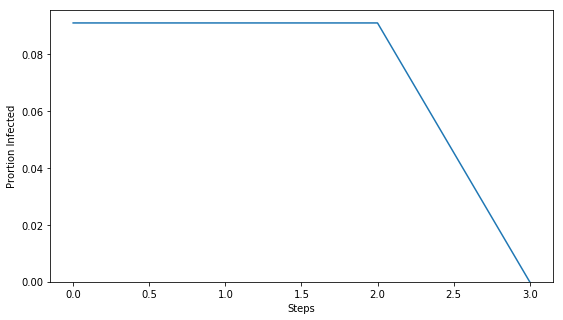

In [7]:
# SIS model (asynchronous) on a random tree
# Does NOT use pycxsimulator
# Uses new Jupyter "widgets" - easier to use

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import IntSlider, Play, jslink, interactive, VBox, HBox
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.0, 5.0]

def observe(state):
    # Set code colors
#     node_color = state/(levels-1) # reflects state of node only

    # if dead, show as black, else use original color for node type
    def f(i):
        if state[i] == 1:
            return 'black'
        else:
            return G.nodes[i]['clr']
    node_color = [f(i) for i in range(N)]

    nx.draw_networkx(G, pos = G.pos, with_labels = True, font_weight='black', node_color='white')
    nx.draw_networkx(G, pos = G.pos, with_labels = False, alpha = 0.4,
        node_color = node_color,
        cmap = plt.cm.rainbow, vmin = 0, vmax = 1)

def draw_hist(step=0):
    observe(state_hist[step])

def update(state):
    new_state = state.copy()
    i = np.random.choice(G.nodes())
    message = "Step %d. Consider state %d -"%(step, i)
    if(state[i] == 0):
        message = message + " currently susceptible."
        j = np.random.choice(list(G.neighbors(i)))
        message = message + " Encounters %d -"%j
        if(state[j] == 0):
            message = message + " not infected."
        else:
            message = message + " infected."
            if(np.random.rand() < p_i):
                new_state[i] = 1
                message = message + " Disease spread to %d."%i
            else:
                message = message + " Disease did not spread to %d."%i
    else:        
        message = message + " currently infected."
        if(np.random.rand() < p_r):
            new_state[i] = 0
            message = message + " Recovers!!"
        else:
            message = message + " Stays infected."
#     print(message)
    return new_state


def grow_random_tree(branches):
    # This is a graph generator specifically for the simulating power grid failures.
    # The rest of use will have different underlying graphs like barabasi-albert, random_partition, etc
    def pick_num_children(b):
        # These are all common ways to choose a random number with mean b
        # Choose your favorite or experiment with all of them
        r = np.random.randint(1,2*b)
#         r = np.random.binomial(2*b, 0.5)
#         r = np.random.normal(b, b/3)
        return round(max(r,1)) # If r < 1, set r=1.  Then round so we return an int
    
    G = nx.Graph()
    G.add_node(0, level=0)
    num_nodes = 1
    G.graph['partition'] = [[0]]
    
    for (depth, brc) in enumerate(branches): # Tracks which level we're on and unpacks the specs for it
        new_nodes = []
        for parent in G.graph['partition'][depth]: # Iterate over nodes in prior level
            num_children = pick_num_children(brc) # For each, randomly choose the number of children
            children = range(num_nodes, num_nodes+num_children)
            G.add_nodes_from(children, depth=depth+1)
            edges = [(parent,child) for child in children]  # connect children to the parent
            G.add_edges_from(edges)
            num_nodes += num_children
            new_nodes.extend(children)
        G.graph['partition'].append(new_nodes) 
        # Note that extend unpacks the new list and inserts as multiple elements, while append adds the list intact as a single new element.
        # If confused, try: a=[1,2]; b=[3,4]; a.extend(b); print(a); a=[1,2]; a.append(b); print(a);
    return G


max_steps = 1000
frame_interval = 1.5 # seconds between frames in animation below
levels = 2 # number of conditions each node could be in.  Ex: infected/susceptible
p_i = 0.1
p_r = 0.9

# Pick the appropriate graph generator for your project
# G  = nx.barabasi_albert_graph(20,4) v
                              
# This graph generator is specific to the power grid group
branches = [8,3,4]
G = grow_random_tree(branches)

# Encode node attributes based on the "partition" it is in
components = ['plant', 'station', 'transformer', 'user']
colors = ['red', 'yellow', 'green', 'blue']
for (depth, nodes) in enumerate(G.graph['partition']):
    for n in nodes:
        G.nodes[n]['cmp'] = components[depth]
        G.node[n]['clr'] = colors[depth]

# Pick the layout
# G.pos = nx.spring_layout(G)
# G.pos = nx.circular_layout(G)
G.pos = nx.kamada_kawai_layout(G)
N = G.number_of_nodes()

# initialize the state
# state = np.random.randint(levels, size=N)
# state = np.zeros(N).astype(int)
state = np.random.binomial(n=1, p=p_i, size=N)

# record every step of the simulation
state_hist = [state]

# run simulation, but do not graph yet.  Just record what happens into state_hist
for step in range(max_steps):
    if state.sum() == 0:
        print('All nodes recovered.  Disease eradicated after %d steps!!' % step)
        break
    state = update(state)
    state_hist.append(state)
max_steps = step
state_hist = np.array(state_hist)


# now, plot it using Jupyter widgets to make interactive WITHOUT pycx simulator
step_slider = IntSlider(min=0, max=max_steps, value=0, description='step')
interactive_plot = interactive(draw_hist, step=step_slider)

play_button = Play(min=0, max=max_steps, interval=frame_interval*1000)
jslink((step_slider, 'value'), (play_button, 'value'))
display(VBox([play_button, interactive_plot]))


# graph infection rates
infection_rates = state_hist.mean(axis=1)
plt.plot(infection_rates)
plt.xlabel('Steps')
plt.ylabel('Prortion Infected')
plt.ylim([0,None])
plt.show()


In [2]:
# Synchronous Multiple-level majority rule (synchronous)
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import IntSlider, Play, jslink, interactive, VBox, HBox
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.0, 5.0]

def observe(state):
    # Set code colors
    
    # reflects state of node only
#     node_color = state/(levels-1) 

    # if dead, show as black, else use original color for node type
    def f(i):
        if(state[i] == 1):
            return 'black'
        else:
            return G.nodes[i]['clr']
    node_color = [f(i) for i in range(N)]

    nx.draw_networkx(G, pos = G.pos, with_labels = True, font_weight='black', node_color='white')
    nx.draw_networkx(G, pos = G.pos, with_labels = False, alpha = 0.4,
        node_color = node_color,
        cmap = plt.cm.rainbow, vmin = 0, vmax = 1)

def draw_hist(i=0):
    observe(state_hist[i])

def update(state):
    next_state = state.copy()
    for i in range(N):
        counts = np.zeros(levels)
        counts[state[i]] += 1
        for j in G.neighbors(i):
            counts[state[j]] += 1

        idx = np.where(counts == counts.max())[0]
        next_state[i] = np.random.choice(idx)

    state, next_state = next_state, state
    return state

def grow_random_tree(branches):
    # This is a graph generator specifically for the group simulating power grid failures.
    # The rest of use will have different underlying graphs like barabasi-albert, random_partition, etc
    def pick_num_children(b):
        # These are all common ways to choose a random number with mean b
        # Choose your favorite or experiment with all of them
        r = np.random.randint(1,2*b)
    #     r = np.random.binomial(2*b, 0.5)
    #     r = np.random.normal(b, b/3)
        return round(max(r,1)) # If r < 1, set r=1.  Then round so we return an int
    
    G = nx.Graph()
    G.add_node(0, level=0)
    num_nodes = 1
    G.graph['partition'] = [[0]]
    
    for (depth, brc) in enumerate(branches): # Tracks which level we're on and unpacks the specs for it
        new_nodes = []
        for parent in G.graph['partition'][depth]: # Iterate over nodes in prior level
            num_children = pick_num_children(brc) # For each, randomly choose the number of children
            children = range(num_nodes, num_nodes+num_children)
            G.add_nodes_from(children, depth=depth+1)
            edges = [(parent,child) for child in children]  # connect children to the parent
            G.add_edges_from(edges)
            num_nodes += num_children
            new_nodes.extend(children)
        G.graph['partition'].append(new_nodes) 
        # Note that extend unpacks the new list and inserts as multiple elements, while append adds the list intact as a single new element.
        # If confused, try: a=[1,2]; b=[3,4]; a.extend(b); print(a); a=[1,2]; a.append(b); print(a);
    return G


max_steps = 10
frame_interval = 1.5 # seconds between frames in animation below
levels = 2 # number of conditions each node could be in.  Ex: infected/susceptible

#A common graph graph generator - pick the appropriate one for your project
# G  = nx.barabasi_albert_graph(20,4) 
                              
# This is specific to the power grid group
branches = [8,3,4]
G = grow_random_tree(branches)

# Encode node attributes based on the "partition" it is in
components = ['plant', 'station', 'transformer', 'user']
colors = ['red', 'yellow', 'green', 'blue']
for (depth, nodes) in enumerate(G.graph['partition']):
    for n in nodes:
        G.nodes[n]['cmp'] = components[depth]
        G.node[n]['clr'] = colors[depth]

# Pick the layout
# G.pos = nx.spring_layout(G)
# G.pos = nx.circular_layout(G)
G.pos = nx.kamada_kawai_layout(G)
N = G.number_of_nodes()

# initialize the state
state = np.random.randint(levels, size=N)
# state = np.zeros(N).astype(int)

# record every step of the simulation
state_hist = [state]

# run simulation, but do not graph yet.  Just record what happens into state_hist
for i in range(max_steps):
    state = update(state)
    state_hist.append(state)

# now, plot it using Jupyter widgets to make interactive WITHOUT pycx simulator
step_slider = IntSlider(min=0, max=max_steps, value=0, description='step')
interactive_plot = interactive(draw_hist, i=step_slider)

play_button = Play(min=0, max=max_steps, interval=frame_interval*1000)
jslink((step_slider, 'value'), (play_button, 'value'))
display(VBox([play_button, interactive_plot]))

A Jupyter Widget